# Exploratory Data Analysis (EDA)

## Objective
Explore historical SpaceX Falcon 9 launch data to identify patterns
and relationships that influence first-stage landing success.

This analysis focuses on the cleaned SpaceX API dataset and aims to
generate insights that will later be incorporated into an interactive
dashboard and machine learning models.


In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [100]:
df = pd.read_csv("../data/processed/spacex_api_clean.csv")

df.shape


(205, 10)

## Dataset Overview

The dataset contains structured launch-level information obtained
from the SpaceX API, including launch outcomes, rocket configuration,
and launch site metadata.


In [101]:
df.head()


,flight_number,name,date_utc,success,rocket,launchpad,payloads,cores,landing_success,launch_date
0,1,FalconSat,2006-03-24T22:30:00.000Z,False,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,['5eb0e4b5b6c3bb0006eeb1e1'],"[{'core': '5e9e289df35918033d3b2623', 'flight'...",0,2006-03-24
1,2,DemoSat,2007-03-21T01:10:00.000Z,False,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,['5eb0e4b6b6c3bb0006eeb1e2'],"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",0,2007-03-21
2,3,Trailblazer,2008-08-03T03:34:00.000Z,False,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,"['5eb0e4b6b6c3bb0006eeb1e3', '5eb0e4b6b6c3bb00...","[{'core': '5e9e289ef3591814873b2625', 'flight'...",0,2008-08-03
3,4,RatSat,2008-09-28T23:15:00.000Z,True,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,['5eb0e4b7b6c3bb0006eeb1e5'],"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",1,2008-09-28
4,5,RazakSat,2009-07-13T03:35:00.000Z,True,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,['5eb0e4b7b6c3bb0006eeb1e6'],"[{'core': '5e9e289ef359184f103b2627', 'flight'...",1,2009-07-13


In [102]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   flight_number    205 non-null    int64 
 1   name             205 non-null    object
 2   date_utc         205 non-null    object
 3   success          186 non-null    object
 4   rocket           205 non-null    object
 5   launchpad        205 non-null    object
 6   payloads         205 non-null    object
 7   cores            205 non-null    object
 8   landing_success  205 non-null    int64 
 9   launch_date      205 non-null    object
dtypes: int64(2), object(8)
memory usage: 16.1+ KB


In [103]:
df["landing_success"].value_counts(normalize=True)


landing_success
1    0.882927
0    0.117073
Name: proportion, dtype: float64

### Overall Landing Success Rate

The distribution of successful versus failed landings provides a
baseline understanding of SpaceX's landing performance over time.


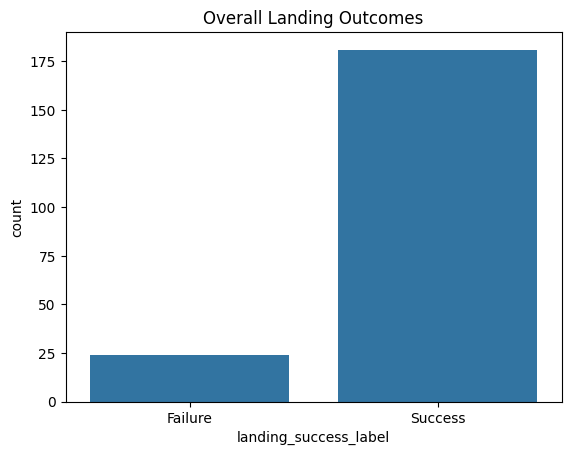

In [104]:
df["landing_success_label"] = df["landing_success"].map({
    0: "Failure",
    1: "Success"
})

sns.countplot(data=df, x="landing_success_label")
plt.title("Overall Landing Outcomes")
plt.show()

### Landing Success by Launch Site

Different launch sites may exhibit varying landing success rates
due to operational, environmental, or historical factors.


In [105]:
success_by_site = (
    df.groupby("launchpad")["landing_success"]
    .mean()
    .sort_values(ascending=False)
)

success_by_site


launchpad
5e9e4502f509094188566f88    0.948276
5e9e4502f509092b78566f87    0.900000
5e9e4501f509094ba4566f84    0.866071
5e9e4502f5090995de566f86    0.400000
Name: landing_success, dtype: float64

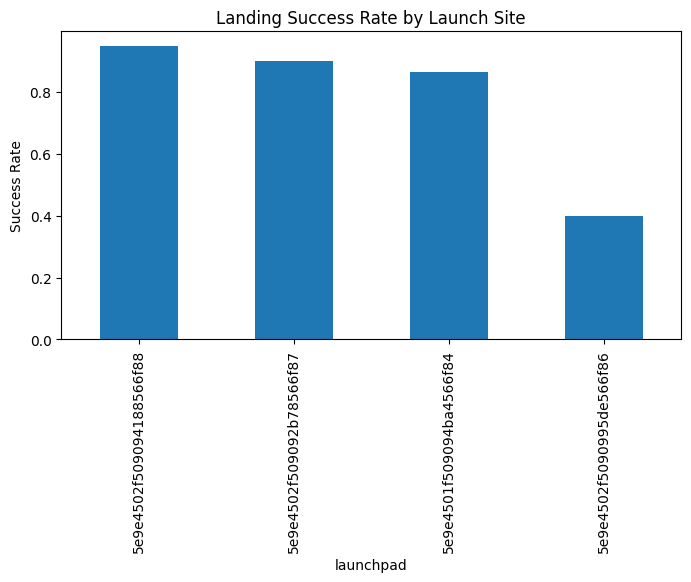

In [106]:
success_by_site.plot(kind="bar", figsize=(8, 4))
plt.ylabel("Success Rate")
plt.title("Landing Success Rate by Launch Site")
plt.show()


### Landing Success by Rocket Configuration

Different rocket and booster configurations may influence
the probability of a successful landing.


In [107]:
success_by_rocket = (
    df.groupby("rocket")["landing_success"]
    .mean()
    .sort_values(ascending=False)
)

success_by_rocket
    

rocket
5e9d0d95eda69973a809d1ec    0.902564
5e9d0d95eda69974db09d1ed    0.600000
5e9d0d95eda69955f709d1eb    0.400000
Name: landing_success, dtype: float64

### Temporal Trends in Landing Success

Analyzing landing success over time helps identify performance
improvements and operational learning effects.


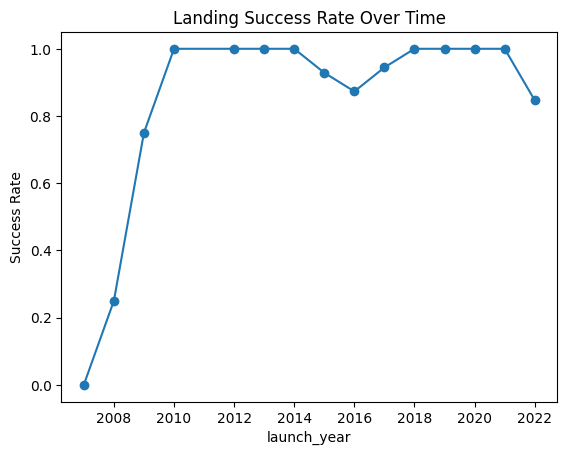

In [108]:
df["launch_year"] = pd.to_datetime(df["launch_date"]).dt.year

success_by_year = (
    df.groupby("launch_year")["landing_success"]
    .mean()
)

success_by_year.rolling(2).mean().plot(marker="o")
plt.ylabel("Success Rate")
plt.title("Landing Success Rate Over Time")
plt.show()


## Geospatial Analysis – Launch Sites Map


In [109]:
# Base map centered roughly over the US
m = folium.Map(
    location=[28.5, -80.5],
    zoom_start=4,
    tiles="CartoDB dark_matter"
)

# Launch sites coordinates (hardcoded = OK for portfolio)
launch_sites = [
    {
        "name": "CCAFS LC-40",
        "lat": 28.5618571,
        "lon": -80.577366
    },
    {
        "name": "KSC LC-39A",
        "lat": 28.6080585,
        "lon": -80.6039558
    },
    {
        "name": "VAFB SLC-4E",
        "lat": 34.632093,
        "lon": -120.610829
    }
]

for site in launch_sites:
    folium.Marker(
        location=[site["lat"], site["lon"]],
        popup=site["name"],
        icon=folium.Icon(color="lightblue", icon="rocket", prefix="fa")
    ).add_to(m)

m


In [110]:
# Save interactive map to HTML
map_path = "../screenshots/folium_map.html"
m.save(map_path)

map_path

'../screenshots/folium_map.html'

## Key EDA Insights

- Landing success rates improve significantly over time,
  reflecting SpaceX's operational learning curve.
- Certain launch sites consistently exhibit higher success rates.
- Rocket configuration plays a measurable role in landing outcomes.

These insights motivate feature selection for machine learning models
and guide the design of interactive dashboard filters.

Overall, the analysis suggests that landing success is strongly
influenced by operational maturity and launch site characteristics.
These findings justify the use of temporal and categorical features
in predictive modeling.



## Next Steps

The insights obtained in this exploratory analysis will be used to:
- Design interactive visualizations in a Dash dashboard
- Select relevant features for machine learning models
- Perform deeper statistical analysis and SQL-based exploration
